# DQN for continuous action space


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.4517179253463817 -2.8040898511585968
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [20]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [21]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [22]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [30]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # nextQs
    gloss = -tf.reduce_mean(gQs) # DPG
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss

In [31]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [32]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, 
                                           g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

In [33]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [34]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [45]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
g_learning_rate = 0.0001         # Q-network learning rate
d_learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 100                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [46]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [47]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # success rate
        gloss_batch, dloss_batch= [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                           feed_dict = {model.states: states, 
                                                        model.actions: actions,
                                                        model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:11.0000 R:11.0000 gloss:0.0305 dloss:1.2345 exploreP:0.9989
Episode:1 meanR:15.0000 R:19.0000 gloss:-0.0349 dloss:1.1890 exploreP:0.9970
Episode:2 meanR:20.3333 R:31.0000 gloss:-0.1353 dloss:1.1023 exploreP:0.9940
Episode:3 meanR:20.0000 R:19.0000 gloss:-0.2376 dloss:1.0405 exploreP:0.9921
Episode:4 meanR:19.4000 R:17.0000 gloss:-0.3211 dloss:1.0083 exploreP:0.9904
Episode:5 meanR:18.0000 R:11.0000 gloss:-0.3910 dloss:0.9983 exploreP:0.9894
Episode:6 meanR:17.2857 R:13.0000 gloss:-0.4624 dloss:0.9984 exploreP:0.9881
Episode:7 meanR:17.5000 R:19.0000 gloss:-0.5652 dloss:1.0388 exploreP:0.9862
Episode:8 meanR:17.1111 R:14.0000 gloss:-0.7000 dloss:1.0960 exploreP:0.9849
Episode:9 meanR:17.2000 R:18.0000 gloss:-0.8503 dloss:1.1937 exploreP:0.9831
Episode:10 meanR:17.6364 R:22.0000 gloss:-1.1220 dloss:1.4901 exploreP:0.9810
Episode:11 meanR:17.5000 R:16.0000 gloss:-1.4767 dloss:1.9853 exploreP:0.9794
Episode:12 meanR:18.3077 R:28.0000 gloss:-2.0768 dloss:3.2097 exploreP:0.97

Episode:95 meanR:20.4167 R:30.0000 gloss:-1994859.8750 dloss:3856083714048.0000 exploreP:0.8238
Episode:96 meanR:20.4021 R:19.0000 gloss:-2162194.0000 dloss:4532922744832.0000 exploreP:0.8222
Episode:97 meanR:20.4184 R:22.0000 gloss:-2321447.7500 dloss:5275285716992.0000 exploreP:0.8205
Episode:98 meanR:20.3535 R:14.0000 gloss:-2486061.2500 dloss:5914173112320.0000 exploreP:0.8193
Episode:99 meanR:20.6200 R:47.0000 gloss:-2759685.0000 dloss:7422315331584.0000 exploreP:0.8155
Episode:100 meanR:20.6200 R:11.0000 gloss:-2995024.0000 dloss:8897859420160.0000 exploreP:0.8146
Episode:101 meanR:20.6800 R:25.0000 gloss:-3231147.5000 dloss:10083929948160.0000 exploreP:0.8126
Episode:102 meanR:20.4600 R:9.0000 gloss:-3401194.7500 dloss:11262922588160.0000 exploreP:0.8119
Episode:103 meanR:20.5700 R:30.0000 gloss:-3616785.7500 dloss:12668166471680.0000 exploreP:0.8095
Episode:104 meanR:20.6400 R:24.0000 gloss:-3985161.2500 dloss:15427768942592.0000 exploreP:0.8076
Episode:105 meanR:20.7200 R:19.0

Episode:180 meanR:18.8300 R:33.0000 gloss:-109342584.0000 dloss:11862286280949760.0000 exploreP:0.7051
Episode:181 meanR:18.8600 R:16.0000 gloss:-113135952.0000 dloss:12653846606118912.0000 exploreP:0.7040
Episode:182 meanR:18.9000 R:30.0000 gloss:-119150200.0000 dloss:13932557154385920.0000 exploreP:0.7019
Episode:183 meanR:18.8900 R:19.0000 gloss:-123770088.0000 dloss:15069023754518528.0000 exploreP:0.7006
Episode:184 meanR:18.8800 R:20.0000 gloss:-129016744.0000 dloss:16216568149049344.0000 exploreP:0.6993
Episode:185 meanR:19.0600 R:28.0000 gloss:-134133440.0000 dloss:17681579346231296.0000 exploreP:0.6973
Episode:186 meanR:18.9700 R:13.0000 gloss:-139385168.0000 dloss:19390916200497152.0000 exploreP:0.6964
Episode:187 meanR:18.9500 R:11.0000 gloss:-143806560.0000 dloss:20179826530844672.0000 exploreP:0.6957
Episode:188 meanR:18.7500 R:17.0000 gloss:-145541392.0000 dloss:20620528830119936.0000 exploreP:0.6945
Episode:189 meanR:18.7100 R:21.0000 gloss:-151507824.0000 dloss:223932078

Episode:260 meanR:17.3800 R:39.0000 gloss:-920585792.0000 dloss:840263965815603200.0000 exploreP:0.6159
Episode:261 meanR:17.2600 R:15.0000 gloss:-959503680.0000 dloss:905269979467743232.0000 exploreP:0.6150
Episode:262 meanR:17.2300 R:9.0000 gloss:-983530624.0000 dloss:985485125150048256.0000 exploreP:0.6144
Episode:263 meanR:17.2200 R:10.0000 gloss:-978006144.0000 dloss:962926788680351744.0000 exploreP:0.6138
Episode:264 meanR:17.2200 R:13.0000 gloss:-1011902912.0000 dloss:1013965156369039360.0000 exploreP:0.6131
Episode:265 meanR:17.2300 R:15.0000 gloss:-1018417344.0000 dloss:1054696564620001280.0000 exploreP:0.6121
Episode:266 meanR:17.2600 R:15.0000 gloss:-1048768256.0000 dloss:1056060714952687616.0000 exploreP:0.6112
Episode:267 meanR:17.3000 R:17.0000 gloss:-1062218112.0000 dloss:1129958754016559104.0000 exploreP:0.6102
Episode:268 meanR:17.4100 R:20.0000 gloss:-1091309056.0000 dloss:1181744927051087872.0000 exploreP:0.6090
Episode:269 meanR:17.4200 R:24.0000 gloss:-1118705664.0

Episode:338 meanR:15.8800 R:13.0000 gloss:-3987666688.0000 dloss:16119254979079831552.0000 exploreP:0.5466
Episode:339 meanR:15.7500 R:13.0000 gloss:-4007506176.0000 dloss:16203253269395406848.0000 exploreP:0.5459
Episode:340 meanR:15.7600 R:11.0000 gloss:-4086771456.0000 dloss:16520312840427405312.0000 exploreP:0.5453
Episode:341 meanR:15.7300 R:11.0000 gloss:-4086108928.0000 dloss:16862032258247163904.0000 exploreP:0.5447
Episode:342 meanR:15.6700 R:8.0000 gloss:-4101699072.0000 dloss:17397031526578782208.0000 exploreP:0.5443
Episode:343 meanR:15.6800 R:14.0000 gloss:-4236875520.0000 dloss:17558024218140999680.0000 exploreP:0.5435
Episode:344 meanR:15.6200 R:11.0000 gloss:-4233154560.0000 dloss:18460633104591618048.0000 exploreP:0.5429
Episode:345 meanR:15.5800 R:11.0000 gloss:-4303296512.0000 dloss:18748111414789931008.0000 exploreP:0.5424
Episode:346 meanR:15.6000 R:12.0000 gloss:-4351618048.0000 dloss:19631918652405579776.0000 exploreP:0.5417
Episode:347 meanR:15.5000 R:10.0000 gl

Episode:417 meanR:13.7400 R:13.0000 gloss:-11615527936.0000 dloss:139286898266756612096.0000 exploreP:0.4916
Episode:418 meanR:13.6900 R:9.0000 gloss:-11286482944.0000 dloss:134656687676424454144.0000 exploreP:0.4912
Episode:419 meanR:13.6800 R:24.0000 gloss:-11851879424.0000 dloss:144278522727185252352.0000 exploreP:0.4901
Episode:420 meanR:13.6500 R:13.0000 gloss:-12113782784.0000 dloss:154060807310764146688.0000 exploreP:0.4894
Episode:421 meanR:13.6500 R:10.0000 gloss:-12118010880.0000 dloss:152692962069252669440.0000 exploreP:0.4890
Episode:422 meanR:13.7300 R:22.0000 gloss:-12464813056.0000 dloss:161437351656676130816.0000 exploreP:0.4879
Episode:423 meanR:13.6800 R:10.0000 gloss:-12338275328.0000 dloss:162868651913249816576.0000 exploreP:0.4874
Episode:424 meanR:13.6900 R:21.0000 gloss:-12706844672.0000 dloss:171842126947343663104.0000 exploreP:0.4864
Episode:425 meanR:13.7300 R:15.0000 gloss:-12934598656.0000 dloss:172961922365628874752.0000 exploreP:0.4857
Episode:426 meanR:13

Episode:495 meanR:13.4800 R:16.0000 gloss:-29509144576.0000 dloss:932274888844479823872.0000 exploreP:0.4430
Episode:496 meanR:13.5100 R:13.0000 gloss:-29425954816.0000 dloss:908397788782579941376.0000 exploreP:0.4425
Episode:497 meanR:13.6200 R:22.0000 gloss:-30168293376.0000 dloss:976119190435536044032.0000 exploreP:0.4415
Episode:498 meanR:13.5300 R:11.0000 gloss:-30400251904.0000 dloss:982086248835569418240.0000 exploreP:0.4410
Episode:499 meanR:13.5400 R:12.0000 gloss:-31078098944.0000 dloss:1007443062850037219328.0000 exploreP:0.4405
Episode:500 meanR:13.4400 R:10.0000 gloss:-31397533696.0000 dloss:1086908444956292022272.0000 exploreP:0.4401
Episode:501 meanR:13.4500 R:12.0000 gloss:-31517386752.0000 dloss:1064485444624079388672.0000 exploreP:0.4396
Episode:502 meanR:13.4800 R:14.0000 gloss:-32034785280.0000 dloss:1088229055178274242560.0000 exploreP:0.4390
Episode:503 meanR:13.5600 R:19.0000 gloss:-32157122560.0000 dloss:1096721788544332333056.0000 exploreP:0.4382
Episode:504 me

Episode:570 meanR:13.2900 R:11.0000 gloss:-64608546816.0000 dloss:4580647209795550445568.0000 exploreP:0.4018
Episode:571 meanR:13.3200 R:12.0000 gloss:-66144235520.0000 dloss:4702278458206735826944.0000 exploreP:0.4013
Episode:572 meanR:13.3600 R:17.0000 gloss:-65847820288.0000 dloss:4796850954156772425728.0000 exploreP:0.4006
Episode:573 meanR:13.3400 R:10.0000 gloss:-67117821952.0000 dloss:4761421698838202155008.0000 exploreP:0.4003
Episode:574 meanR:13.2900 R:9.0000 gloss:-67677134848.0000 dloss:4939706260236871401472.0000 exploreP:0.3999
Episode:575 meanR:13.3000 R:14.0000 gloss:-66426523648.0000 dloss:4750029280630815064064.0000 exploreP:0.3994
Episode:576 meanR:13.3100 R:15.0000 gloss:-68792033280.0000 dloss:5164357068649180168192.0000 exploreP:0.3988
Episode:577 meanR:13.3000 R:8.0000 gloss:-69568806912.0000 dloss:5116199514883754033152.0000 exploreP:0.3985
Episode:578 meanR:13.2100 R:11.0000 gloss:-68554244096.0000 dloss:5269557215294881005568.0000 exploreP:0.3980
Episode:579 

Episode:650 meanR:11.8500 R:10.0000 gloss:-128478568448.0000 dloss:17720886536867273506816.0000 exploreP:0.3668
Episode:651 meanR:11.8000 R:9.0000 gloss:-130388942848.0000 dloss:18676808208873959718912.0000 exploreP:0.3665
Episode:652 meanR:11.8200 R:16.0000 gloss:-130792538112.0000 dloss:18800499572639690391552.0000 exploreP:0.3659
Episode:653 meanR:11.8000 R:9.0000 gloss:-131761889280.0000 dloss:18752353840823286104064.0000 exploreP:0.3656
Episode:654 meanR:11.8000 R:11.0000 gloss:-132755095552.0000 dloss:19070271945718624157696.0000 exploreP:0.3652
Episode:655 meanR:11.7200 R:10.0000 gloss:-135319429120.0000 dloss:19842267734843406155776.0000 exploreP:0.3649
Episode:656 meanR:11.7100 R:12.0000 gloss:-134815940608.0000 dloss:20007612891562686545920.0000 exploreP:0.3644
Episode:657 meanR:11.7600 R:16.0000 gloss:-134460399616.0000 dloss:19532548433069696090112.0000 exploreP:0.3639
Episode:658 meanR:11.7600 R:11.0000 gloss:-138424598528.0000 dloss:20628427344796268363776.0000 exploreP:0

Episode:727 meanR:11.5300 R:13.0000 gloss:-235796840448.0000 dloss:59801885321569822048256.0000 exploreP:0.3363
Episode:728 meanR:11.5300 R:11.0000 gloss:-234128457728.0000 dloss:59148070742066682920960.0000 exploreP:0.3360
Episode:729 meanR:11.5500 R:12.0000 gloss:-238891433984.0000 dloss:62054275106806255583232.0000 exploreP:0.3356
Episode:730 meanR:11.5700 R:11.0000 gloss:-239695396864.0000 dloss:62874268008959738642432.0000 exploreP:0.3352
Episode:731 meanR:11.5200 R:12.0000 gloss:-244759773184.0000 dloss:65227853677823187222528.0000 exploreP:0.3348
Episode:732 meanR:11.4700 R:10.0000 gloss:-246418341888.0000 dloss:65327657949165344784384.0000 exploreP:0.3345
Episode:733 meanR:11.4700 R:13.0000 gloss:-245742714880.0000 dloss:68194649471949402537984.0000 exploreP:0.3341
Episode:734 meanR:11.5100 R:13.0000 gloss:-242489475072.0000 dloss:64050356030049779449856.0000 exploreP:0.3337
Episode:735 meanR:11.5700 R:17.0000 gloss:-252145434624.0000 dloss:67866210958324527005696.0000 exploreP

Episode:803 meanR:11.5600 R:14.0000 gloss:-405359558656.0000 dloss:179956671379118246330368.0000 exploreP:0.3090
Episode:804 meanR:11.5400 R:12.0000 gloss:-411493695488.0000 dloss:188386815406405001936896.0000 exploreP:0.3087
Episode:805 meanR:11.5000 R:9.0000 gloss:-410841120768.0000 dloss:179644571924941470957568.0000 exploreP:0.3084
Episode:806 meanR:11.4900 R:10.0000 gloss:-408762023936.0000 dloss:183173736708137067479040.0000 exploreP:0.3081
Episode:807 meanR:11.5100 R:11.0000 gloss:-417979727872.0000 dloss:184524726524355668869120.0000 exploreP:0.3078
Episode:808 meanR:11.5400 R:13.0000 gloss:-412335865856.0000 dloss:188651807208479481921536.0000 exploreP:0.3074
Episode:809 meanR:11.5400 R:11.0000 gloss:-419534929920.0000 dloss:191733134044729356320768.0000 exploreP:0.3071
Episode:810 meanR:11.5600 R:12.0000 gloss:-419467722752.0000 dloss:191682801815293863657472.0000 exploreP:0.3067
Episode:811 meanR:11.5700 R:13.0000 gloss:-428997574656.0000 dloss:196605110107220249411584.0000 

Episode:878 meanR:11.4200 R:9.0000 gloss:-677009948672.0000 dloss:497851934017146276806656.0000 exploreP:0.2844
Episode:879 meanR:11.4300 R:11.0000 gloss:-672558678016.0000 dloss:488620347414571177213952.0000 exploreP:0.2841
Episode:880 meanR:11.4600 R:13.0000 gloss:-677408473088.0000 dloss:491247170976426821156864.0000 exploreP:0.2838
Episode:881 meanR:11.4300 R:9.0000 gloss:-670680154112.0000 dloss:501419325353978994098176.0000 exploreP:0.2835
Episode:882 meanR:11.4200 R:9.0000 gloss:-682262855680.0000 dloss:490167207785783376216064.0000 exploreP:0.2833
Episode:883 meanR:11.4000 R:12.0000 gloss:-684029181952.0000 dloss:517716663455131193311232.0000 exploreP:0.2830
Episode:884 meanR:11.4000 R:10.0000 gloss:-687229632512.0000 dloss:527014182756250996965376.0000 exploreP:0.2827
Episode:885 meanR:11.3700 R:8.0000 gloss:-696415879168.0000 dloss:516197617315217634492416.0000 exploreP:0.2825
Episode:886 meanR:11.3700 R:13.0000 gloss:-684454182912.0000 dloss:509120660860767637078016.0000 exp

Episode:955 meanR:11.0300 R:13.0000 gloss:-1053421731840.0000 dloss:1202769146722434573926400.0000 exploreP:0.2622
Episode:956 meanR:11.0000 R:10.0000 gloss:-1024474349568.0000 dloss:1135958210221596246802432.0000 exploreP:0.2620
Episode:957 meanR:10.9900 R:9.0000 gloss:-1043247726592.0000 dloss:1191810195475582265851904.0000 exploreP:0.2617
Episode:958 meanR:10.9400 R:8.0000 gloss:-1051293581312.0000 dloss:1236017457360257016659968.0000 exploreP:0.2615
Episode:959 meanR:10.9300 R:10.0000 gloss:-1062514327552.0000 dloss:1279071149221978579140608.0000 exploreP:0.2613
Episode:960 meanR:10.9100 R:9.0000 gloss:-1057849606144.0000 dloss:1218097166068588566544384.0000 exploreP:0.2611
Episode:961 meanR:10.9000 R:9.0000 gloss:-1081583665152.0000 dloss:1283628359699313293524992.0000 exploreP:0.2608
Episode:962 meanR:10.9000 R:10.0000 gloss:-1099149344768.0000 dloss:1297352593174965124071424.0000 exploreP:0.2606
Episode:963 meanR:10.8000 R:13.0000 gloss:-1088729841664.0000 dloss:1300820725176010

Episode:1028 meanR:10.5500 R:9.0000 gloss:-1535663276032.0000 dloss:2684746050016715783274496.0000 exploreP:0.2436
Episode:1029 meanR:10.4900 R:9.0000 gloss:-1533004349440.0000 dloss:2608584343652763623751680.0000 exploreP:0.2434
Episode:1030 meanR:10.4700 R:8.0000 gloss:-1528417484800.0000 dloss:2670909839039929012715520.0000 exploreP:0.2432
Episode:1031 meanR:10.4500 R:8.0000 gloss:-1553366777856.0000 dloss:2719010588903255123689472.0000 exploreP:0.2431
Episode:1032 meanR:10.4400 R:9.0000 gloss:-1544713011200.0000 dloss:2697365352345390026850304.0000 exploreP:0.2429
Episode:1033 meanR:10.4700 R:13.0000 gloss:-1552290414592.0000 dloss:2719719059167836031156224.0000 exploreP:0.2425
Episode:1034 meanR:10.4900 R:11.0000 gloss:-1591486840832.0000 dloss:2763611645539347150667776.0000 exploreP:0.2423
Episode:1035 meanR:10.5000 R:13.0000 gloss:-1560784928768.0000 dloss:2660504722460852218757120.0000 exploreP:0.2420
Episode:1036 meanR:10.4800 R:10.0000 gloss:-1629305831424.0000 dloss:28981244

Episode:1100 meanR:10.8700 R:10.0000 gloss:-2250406887424.0000 dloss:5415358199790453456371712.0000 exploreP:0.2259
Episode:1101 meanR:10.8600 R:11.0000 gloss:-2252238749696.0000 dloss:5475545314016949295906816.0000 exploreP:0.2257
Episode:1102 meanR:10.8700 R:10.0000 gloss:-2276015472640.0000 dloss:5646563925402805942091776.0000 exploreP:0.2255
Episode:1103 meanR:10.8800 R:11.0000 gloss:-2279446151168.0000 dloss:5589464911426399542181888.0000 exploreP:0.2253
Episode:1104 meanR:10.8900 R:10.0000 gloss:-2290068750336.0000 dloss:5747850385425526662627328.0000 exploreP:0.2250
Episode:1105 meanR:10.8800 R:9.0000 gloss:-2338969878528.0000 dloss:5857186543393412388749312.0000 exploreP:0.2248
Episode:1106 meanR:10.8500 R:9.0000 gloss:-2275180281856.0000 dloss:5799022229946749262233600.0000 exploreP:0.2246
Episode:1107 meanR:10.8200 R:8.0000 gloss:-2295834607616.0000 dloss:5965932405550939409219584.0000 exploreP:0.2245
Episode:1108 meanR:10.8600 R:14.0000 gloss:-2371070459904.0000 dloss:599736

Episode:1175 meanR:10.7000 R:11.0000 gloss:-3219648675840.0000 dloss:11238411349118475533549568.0000 exploreP:0.2090
Episode:1176 meanR:10.6900 R:8.0000 gloss:-3219133038592.0000 dloss:11117818065579608553553920.0000 exploreP:0.2089
Episode:1177 meanR:10.7100 R:10.0000 gloss:-3225586237440.0000 dloss:11083665071848639925583872.0000 exploreP:0.2087
Episode:1178 meanR:10.7100 R:10.0000 gloss:-3311128281088.0000 dloss:11510165324047850827415552.0000 exploreP:0.2085
Episode:1179 meanR:10.7200 R:11.0000 gloss:-3228579135488.0000 dloss:11502840813729083528577024.0000 exploreP:0.2083
Episode:1180 meanR:10.7600 R:12.0000 gloss:-3306293559296.0000 dloss:11939422211564576700366848.0000 exploreP:0.2080
Episode:1181 meanR:10.7200 R:10.0000 gloss:-3342586347520.0000 dloss:12504558968849751737368576.0000 exploreP:0.2078
Episode:1182 meanR:10.8200 R:19.0000 gloss:-3381195440128.0000 dloss:12359550266607825558962176.0000 exploreP:0.2075
Episode:1183 meanR:10.7800 R:10.0000 gloss:-3437370015744.0000 dl

Episode:1248 meanR:10.8600 R:11.0000 gloss:-4489875554304.0000 dloss:22378407012760701395533824.0000 exploreP:0.1938
Episode:1249 meanR:10.8200 R:9.0000 gloss:-4618213392384.0000 dloss:23548218817410038679732224.0000 exploreP:0.1936
Episode:1250 meanR:10.8100 R:10.0000 gloss:-4543085543424.0000 dloss:22530590345525795982671872.0000 exploreP:0.1934
Episode:1251 meanR:10.7700 R:10.0000 gloss:-4580764024832.0000 dloss:22945817331252961134772224.0000 exploreP:0.1932
Episode:1252 meanR:10.7700 R:10.0000 gloss:-4563372867584.0000 dloss:22985205741536349454860288.0000 exploreP:0.1930
Episode:1253 meanR:10.7500 R:9.0000 gloss:-4743322140672.0000 dloss:24375202495135502374535168.0000 exploreP:0.1929
Episode:1254 meanR:10.7900 R:12.0000 gloss:-4670977736704.0000 dloss:23501002070110369868677120.0000 exploreP:0.1927
Episode:1255 meanR:10.8100 R:13.0000 gloss:-4650302439424.0000 dloss:24346557007432040654569472.0000 exploreP:0.1924
Episode:1256 meanR:10.8100 R:10.0000 gloss:-4805528911872.0000 dlo

Episode:1321 meanR:10.6600 R:11.0000 gloss:-6304210878464.0000 dloss:41358448763484205362446336.0000 exploreP:0.1801
Episode:1322 meanR:10.6600 R:9.0000 gloss:-6178264842240.0000 dloss:44719473203830196231208960.0000 exploreP:0.1800
Episode:1323 meanR:10.6600 R:10.0000 gloss:-6206885724160.0000 dloss:42795320999617663466471424.0000 exploreP:0.1798
Episode:1324 meanR:10.6100 R:8.0000 gloss:-6324284293120.0000 dloss:43622371546790394358398976.0000 exploreP:0.1797
Episode:1325 meanR:10.6100 R:10.0000 gloss:-6395828109312.0000 dloss:45922772766502343992672256.0000 exploreP:0.1795
Episode:1326 meanR:10.5700 R:9.0000 gloss:-6362776469504.0000 dloss:43987077512185687476011008.0000 exploreP:0.1794
Episode:1327 meanR:10.5800 R:12.0000 gloss:-6422066102272.0000 dloss:46100995984370488825610240.0000 exploreP:0.1792
Episode:1328 meanR:10.5700 R:10.0000 gloss:-6445235961856.0000 dloss:44083503255144985729695744.0000 exploreP:0.1790
Episode:1329 meanR:10.5800 R:11.0000 gloss:-6551440457728.0000 dlos

Episode:1396 meanR:10.4900 R:11.0000 gloss:-8560063283200.0000 dloss:78503615063672964861919232.0000 exploreP:0.1673
Episode:1397 meanR:10.5000 R:10.0000 gloss:-8712600158208.0000 dloss:82540223835602457494290432.0000 exploreP:0.1671
Episode:1398 meanR:10.4900 R:9.0000 gloss:-8716711624704.0000 dloss:84449148252582143024168960.0000 exploreP:0.1670
Episode:1399 meanR:10.4800 R:8.0000 gloss:-8795956707328.0000 dloss:84129493847900867058991104.0000 exploreP:0.1669
Episode:1400 meanR:10.4900 R:10.0000 gloss:-8582383796224.0000 dloss:82779275192053659573682176.0000 exploreP:0.1667
Episode:1401 meanR:10.4600 R:8.0000 gloss:-8616130641920.0000 dloss:82492723469612655398879232.0000 exploreP:0.1666
Episode:1402 meanR:10.4700 R:10.0000 gloss:-8738398797824.0000 dloss:83744159810945148235284480.0000 exploreP:0.1664
Episode:1403 meanR:10.4300 R:9.0000 gloss:-8853456420864.0000 dloss:85480782414904349698293760.0000 exploreP:0.1663
Episode:1404 meanR:10.3600 R:10.0000 gloss:-8710852182016.0000 dloss

Episode:1468 meanR:10.0600 R:9.0000 gloss:-11409174822912.0000 dloss:138651400831803655632977920.0000 exploreP:0.1564
Episode:1469 meanR:10.0400 R:10.0000 gloss:-11349789769728.0000 dloss:138888164791989717727969280.0000 exploreP:0.1562
Episode:1470 meanR:10.0400 R:10.0000 gloss:-11212375982080.0000 dloss:141134858316331062002712576.0000 exploreP:0.1561
Episode:1471 meanR:10.0600 R:11.0000 gloss:-11390051942400.0000 dloss:143611739536596190917296128.0000 exploreP:0.1559
Episode:1472 meanR:10.0400 R:10.0000 gloss:-11394183331840.0000 dloss:143792858893283908149837824.0000 exploreP:0.1558
Episode:1473 meanR:10.0500 R:9.0000 gloss:-11440603791360.0000 dloss:145888169212384354989244416.0000 exploreP:0.1556
Episode:1474 meanR:10.0700 R:10.0000 gloss:-11518623088640.0000 dloss:149694562618273952417447936.0000 exploreP:0.1555
Episode:1475 meanR:10.0500 R:8.0000 gloss:-11452048998400.0000 dloss:144336696578692976295804928.0000 exploreP:0.1554
Episode:1476 meanR:10.0500 R:11.0000 gloss:-1151443

Episode:1540 meanR:10.0100 R:11.0000 gloss:-14572954058752.0000 dloss:239520309579043923612925952.0000 exploreP:0.1462
Episode:1541 meanR:10.0200 R:10.0000 gloss:-14731164254208.0000 dloss:243925945466167975825375232.0000 exploreP:0.1460
Episode:1542 meanR:10.0100 R:10.0000 gloss:-14906153762816.0000 dloss:239377144398287863782834176.0000 exploreP:0.1459
Episode:1543 meanR:10.0000 R:8.0000 gloss:-14733308592128.0000 dloss:246750105090364760758681600.0000 exploreP:0.1458
Episode:1544 meanR:9.9900 R:10.0000 gloss:-14716263989248.0000 dloss:243342917672974311736999936.0000 exploreP:0.1457
Episode:1545 meanR:10.0000 R:10.0000 gloss:-14963036913664.0000 dloss:240929714613251628194594816.0000 exploreP:0.1455
Episode:1546 meanR:10.0100 R:10.0000 gloss:-14664362622976.0000 dloss:244457912671765611874877440.0000 exploreP:0.1454
Episode:1547 meanR:9.9600 R:9.0000 gloss:-14883676487680.0000 dloss:241454081760290895908831232.0000 exploreP:0.1453
Episode:1548 meanR:9.9800 R:11.0000 gloss:-151605844

Episode:1611 meanR:10.0300 R:9.0000 gloss:-18336182173696.0000 dloss:379094351985810273034305536.0000 exploreP:0.1368
Episode:1612 meanR:10.0200 R:9.0000 gloss:-18902736175104.0000 dloss:398249524818926566270566400.0000 exploreP:0.1367
Episode:1613 meanR:10.0300 R:11.0000 gloss:-18638102855680.0000 dloss:385833427211282288687972352.0000 exploreP:0.1365
Episode:1614 meanR:10.0200 R:10.0000 gloss:-18964486815744.0000 dloss:394942208073951180761333760.0000 exploreP:0.1364
Episode:1615 meanR:10.0200 R:10.0000 gloss:-19096917770240.0000 dloss:409503256188998257586733056.0000 exploreP:0.1363
Episode:1616 meanR:10.0300 R:12.0000 gloss:-19600154558464.0000 dloss:410012792153802262821470208.0000 exploreP:0.1361
Episode:1617 meanR:10.0400 R:11.0000 gloss:-18961318019072.0000 dloss:412013562909524948208844800.0000 exploreP:0.1360
Episode:1618 meanR:10.0400 R:10.0000 gloss:-19253201731584.0000 dloss:393265472824627277357645824.0000 exploreP:0.1359
Episode:1619 meanR:10.0600 R:12.0000 gloss:-192129

Episode:1683 meanR:9.9200 R:12.0000 gloss:-24175272001536.0000 dloss:622144999445680730635501568.0000 exploreP:0.1281
Episode:1684 meanR:9.9400 R:12.0000 gloss:-24433104257024.0000 dloss:653779394644661535539986432.0000 exploreP:0.1279
Episode:1685 meanR:9.9400 R:9.0000 gloss:-24298108485632.0000 dloss:650463186569042622026874880.0000 exploreP:0.1278
Episode:1686 meanR:9.9300 R:10.0000 gloss:-24233803513856.0000 dloss:621215283544365769234055168.0000 exploreP:0.1277
Episode:1687 meanR:9.9200 R:9.0000 gloss:-24043652644864.0000 dloss:650376486871896187134279680.0000 exploreP:0.1276
Episode:1688 meanR:9.9400 R:11.0000 gloss:-24077769113600.0000 dloss:659413030284772432603512832.0000 exploreP:0.1275
Episode:1689 meanR:9.9600 R:11.0000 gloss:-24731046641664.0000 dloss:672208060909178851795402752.0000 exploreP:0.1273
Episode:1690 meanR:9.9200 R:9.0000 gloss:-24922795540480.0000 dloss:686488349579424069245206528.0000 exploreP:0.1272
Episode:1691 meanR:9.9300 R:11.0000 gloss:-24285118726144.0

Episode:1756 meanR:9.8400 R:12.0000 gloss:-30705316790272.0000 dloss:1031909904252620484502355968.0000 exploreP:0.1198
Episode:1757 meanR:9.8500 R:10.0000 gloss:-30494045503488.0000 dloss:1014957125087952522052632576.0000 exploreP:0.1197
Episode:1758 meanR:9.8400 R:9.0000 gloss:-30721332740096.0000 dloss:1061943712361813659032223744.0000 exploreP:0.1196
Episode:1759 meanR:9.8300 R:8.0000 gloss:-30396941074432.0000 dloss:1004401307833165557912305664.0000 exploreP:0.1196
Episode:1760 meanR:9.8500 R:12.0000 gloss:-30795160879104.0000 dloss:994168308599668510925258752.0000 exploreP:0.1194
Episode:1761 meanR:9.8300 R:8.0000 gloss:-30877375528960.0000 dloss:1036822714921307107126935552.0000 exploreP:0.1193
Episode:1762 meanR:9.8100 R:8.0000 gloss:-30568632811520.0000 dloss:1058968104968771718680150016.0000 exploreP:0.1192
Episode:1763 meanR:9.8000 R:10.0000 gloss:-30921193422848.0000 dloss:1056724980889408637203644416.0000 exploreP:0.1191
Episode:1764 meanR:9.7900 R:10.0000 gloss:-3077941755

Episode:1831 meanR:10.0700 R:10.0000 gloss:-38947451305984.0000 dloss:1708235942521837961762308096.0000 exploreP:0.1118
Episode:1832 meanR:10.0600 R:10.0000 gloss:-39295507234816.0000 dloss:1709326956753333439483084800.0000 exploreP:0.1117
Episode:1833 meanR:10.0000 R:8.0000 gloss:-38645377531904.0000 dloss:1635136808420020237058965504.0000 exploreP:0.1117
Episode:1834 meanR:9.9800 R:11.0000 gloss:-39681869742080.0000 dloss:1715351958515712158393696256.0000 exploreP:0.1115
Episode:1835 meanR:9.9800 R:9.0000 gloss:-39451686338560.0000 dloss:1700780211289102330028359680.0000 exploreP:0.1115
Episode:1836 meanR:10.0100 R:12.0000 gloss:-39521328562176.0000 dloss:1759433773893774399699419136.0000 exploreP:0.1113
Episode:1837 meanR:10.0100 R:9.0000 gloss:-39599443279872.0000 dloss:1746661100723185316484087808.0000 exploreP:0.1112
Episode:1838 meanR:10.0200 R:11.0000 gloss:-39988246872064.0000 dloss:1764286890898638498214969344.0000 exploreP:0.1111
Episode:1839 meanR:10.0200 R:9.0000 gloss:-39

Episode:1905 meanR:10.0700 R:10.0000 gloss:-48872030208000.0000 dloss:2789936043999618255737061376.0000 exploreP:0.1046
Episode:1906 meanR:10.0900 R:12.0000 gloss:-48759081795584.0000 dloss:2688125364403810857163685888.0000 exploreP:0.1045
Episode:1907 meanR:10.0500 R:10.0000 gloss:-48044586303488.0000 dloss:2698495386052287418700136448.0000 exploreP:0.1044
Episode:1908 meanR:10.0300 R:8.0000 gloss:-48368906665984.0000 dloss:2748789179390659498931650560.0000 exploreP:0.1043
Episode:1909 meanR:10.0500 R:12.0000 gloss:-49875374833664.0000 dloss:2889311163081885634791473152.0000 exploreP:0.1042
Episode:1910 meanR:10.0500 R:10.0000 gloss:-49745494016000.0000 dloss:2667724150902003631134867456.0000 exploreP:0.1041
Episode:1911 meanR:10.0500 R:10.0000 gloss:-50455673569280.0000 dloss:2680730728787447351464689664.0000 exploreP:0.1040
Episode:1912 meanR:10.0400 R:9.0000 gloss:-50251108974592.0000 dloss:2689695846407270193550065664.0000 exploreP:0.1039
Episode:1913 meanR:10.0300 R:9.0000 gloss:

Episode:1979 meanR:10.0200 R:12.0000 gloss:nan dloss:nan exploreP:0.0978
Episode:1980 meanR:10.0200 R:12.0000 gloss:nan dloss:nan exploreP:0.0977
Episode:1981 meanR:10.0300 R:10.0000 gloss:nan dloss:nan exploreP:0.0976
Episode:1982 meanR:10.0400 R:11.0000 gloss:nan dloss:nan exploreP:0.0975
Episode:1983 meanR:10.0300 R:9.0000 gloss:nan dloss:nan exploreP:0.0974
Episode:1984 meanR:10.0200 R:9.0000 gloss:nan dloss:nan exploreP:0.0973
Episode:1985 meanR:10.0200 R:10.0000 gloss:nan dloss:nan exploreP:0.0973
Episode:1986 meanR:10.0300 R:11.0000 gloss:nan dloss:nan exploreP:0.0972
Episode:1987 meanR:10.0400 R:9.0000 gloss:nan dloss:nan exploreP:0.0971
Episode:1988 meanR:10.0600 R:11.0000 gloss:nan dloss:nan exploreP:0.0970
Episode:1989 meanR:10.0400 R:9.0000 gloss:nan dloss:nan exploreP:0.0969
Episode:1990 meanR:10.0400 R:10.0000 gloss:nan dloss:nan exploreP:0.0968
Episode:1991 meanR:10.0300 R:9.0000 gloss:nan dloss:nan exploreP:0.0967
Episode:1992 meanR:10.0300 R:10.0000 gloss:nan dloss:nan

Episode:2093 meanR:9.9100 R:10.0000 gloss:nan dloss:nan exploreP:0.0884
Episode:2094 meanR:9.9000 R:10.0000 gloss:nan dloss:nan exploreP:0.0883
Episode:2095 meanR:9.9400 R:13.0000 gloss:nan dloss:nan exploreP:0.0882
Episode:2096 meanR:9.9200 R:9.0000 gloss:nan dloss:nan exploreP:0.0881
Episode:2097 meanR:9.9200 R:10.0000 gloss:nan dloss:nan exploreP:0.0881
Episode:2098 meanR:9.9300 R:11.0000 gloss:nan dloss:nan exploreP:0.0880
Episode:2099 meanR:9.9300 R:9.0000 gloss:nan dloss:nan exploreP:0.0879
Episode:2100 meanR:9.9300 R:11.0000 gloss:nan dloss:nan exploreP:0.0878
Episode:2101 meanR:9.9500 R:12.0000 gloss:nan dloss:nan exploreP:0.0877
Episode:2102 meanR:9.9500 R:10.0000 gloss:nan dloss:nan exploreP:0.0877
Episode:2103 meanR:9.9500 R:9.0000 gloss:nan dloss:nan exploreP:0.0876
Episode:2104 meanR:9.9900 R:12.0000 gloss:nan dloss:nan exploreP:0.0875
Episode:2105 meanR:10.0000 R:10.0000 gloss:nan dloss:nan exploreP:0.0874
Episode:2106 meanR:10.0000 R:11.0000 gloss:nan dloss:nan exploreP:

Episode:2212 meanR:9.7200 R:10.0000 gloss:nan dloss:nan exploreP:0.0798
Episode:2213 meanR:9.7100 R:10.0000 gloss:nan dloss:nan exploreP:0.0797
Episode:2214 meanR:9.7200 R:10.0000 gloss:nan dloss:nan exploreP:0.0796
Episode:2215 meanR:9.7100 R:9.0000 gloss:nan dloss:nan exploreP:0.0796
Episode:2216 meanR:9.7300 R:14.0000 gloss:nan dloss:nan exploreP:0.0795
Episode:2217 meanR:9.7400 R:10.0000 gloss:nan dloss:nan exploreP:0.0794
Episode:2218 meanR:9.7700 R:11.0000 gloss:nan dloss:nan exploreP:0.0793
Episode:2219 meanR:9.7800 R:10.0000 gloss:nan dloss:nan exploreP:0.0792
Episode:2220 meanR:9.8000 R:10.0000 gloss:nan dloss:nan exploreP:0.0792
Episode:2221 meanR:9.8100 R:9.0000 gloss:nan dloss:nan exploreP:0.0791
Episode:2222 meanR:9.8000 R:10.0000 gloss:nan dloss:nan exploreP:0.0790
Episode:2223 meanR:9.7900 R:10.0000 gloss:nan dloss:nan exploreP:0.0790
Episode:2224 meanR:9.7900 R:9.0000 gloss:nan dloss:nan exploreP:0.0789
Episode:2225 meanR:9.7900 R:10.0000 gloss:nan dloss:nan exploreP:0.

Episode:2330 meanR:9.7600 R:9.0000 gloss:nan dloss:nan exploreP:0.0721
Episode:2331 meanR:9.7700 R:10.0000 gloss:nan dloss:nan exploreP:0.0721
Episode:2332 meanR:9.7600 R:9.0000 gloss:nan dloss:nan exploreP:0.0720
Episode:2333 meanR:9.7500 R:9.0000 gloss:nan dloss:nan exploreP:0.0719
Episode:2334 meanR:9.7500 R:10.0000 gloss:nan dloss:nan exploreP:0.0719
Episode:2335 meanR:9.7500 R:9.0000 gloss:nan dloss:nan exploreP:0.0718
Episode:2336 meanR:9.7400 R:9.0000 gloss:nan dloss:nan exploreP:0.0718
Episode:2337 meanR:9.7500 R:9.0000 gloss:nan dloss:nan exploreP:0.0717
Episode:2338 meanR:9.7600 R:10.0000 gloss:nan dloss:nan exploreP:0.0717
Episode:2339 meanR:9.7500 R:8.0000 gloss:nan dloss:nan exploreP:0.0716
Episode:2340 meanR:9.7400 R:9.0000 gloss:nan dloss:nan exploreP:0.0716
Episode:2341 meanR:9.7400 R:9.0000 gloss:nan dloss:nan exploreP:0.0715
Episode:2342 meanR:9.7800 R:12.0000 gloss:nan dloss:nan exploreP:0.0714
Episode:2343 meanR:9.7600 R:9.0000 gloss:nan dloss:nan exploreP:0.0714
Ep

Episode:2449 meanR:9.7700 R:10.0000 gloss:nan dloss:nan exploreP:0.0653
Episode:2450 meanR:9.7500 R:9.0000 gloss:nan dloss:nan exploreP:0.0653
Episode:2451 meanR:9.7400 R:10.0000 gloss:nan dloss:nan exploreP:0.0652
Episode:2452 meanR:9.7300 R:9.0000 gloss:nan dloss:nan exploreP:0.0652
Episode:2453 meanR:9.7300 R:9.0000 gloss:nan dloss:nan exploreP:0.0651
Episode:2454 meanR:9.7400 R:10.0000 gloss:nan dloss:nan exploreP:0.0651
Episode:2455 meanR:9.7500 R:10.0000 gloss:nan dloss:nan exploreP:0.0650
Episode:2456 meanR:9.7800 R:11.0000 gloss:nan dloss:nan exploreP:0.0650
Episode:2457 meanR:9.7700 R:10.0000 gloss:nan dloss:nan exploreP:0.0649
Episode:2458 meanR:9.7700 R:10.0000 gloss:nan dloss:nan exploreP:0.0649
Episode:2459 meanR:9.7800 R:10.0000 gloss:nan dloss:nan exploreP:0.0648
Episode:2460 meanR:9.7800 R:10.0000 gloss:nan dloss:nan exploreP:0.0647
Episode:2461 meanR:9.7900 R:10.0000 gloss:nan dloss:nan exploreP:0.0647
Episode:2462 meanR:9.7900 R:10.0000 gloss:nan dloss:nan exploreP:0.

Episode:2565 meanR:9.7600 R:9.0000 gloss:nan dloss:nan exploreP:0.0594
Episode:2566 meanR:9.7600 R:10.0000 gloss:nan dloss:nan exploreP:0.0594
Episode:2567 meanR:9.7600 R:9.0000 gloss:nan dloss:nan exploreP:0.0593
Episode:2568 meanR:9.7600 R:9.0000 gloss:nan dloss:nan exploreP:0.0593
Episode:2569 meanR:9.7700 R:10.0000 gloss:nan dloss:nan exploreP:0.0592
Episode:2570 meanR:9.7700 R:9.0000 gloss:nan dloss:nan exploreP:0.0592
Episode:2571 meanR:9.7700 R:9.0000 gloss:nan dloss:nan exploreP:0.0591
Episode:2572 meanR:9.7600 R:9.0000 gloss:nan dloss:nan exploreP:0.0591
Episode:2573 meanR:9.7500 R:10.0000 gloss:nan dloss:nan exploreP:0.0590
Episode:2574 meanR:9.7300 R:10.0000 gloss:nan dloss:nan exploreP:0.0590
Episode:2575 meanR:9.7100 R:8.0000 gloss:nan dloss:nan exploreP:0.0590
Episode:2576 meanR:9.7000 R:9.0000 gloss:nan dloss:nan exploreP:0.0589
Episode:2577 meanR:9.6900 R:9.0000 gloss:nan dloss:nan exploreP:0.0589
Episode:2578 meanR:9.6700 R:8.0000 gloss:nan dloss:nan exploreP:0.0588
Ep

Episode:2683 meanR:9.5500 R:9.0000 gloss:nan dloss:nan exploreP:0.0542
Episode:2684 meanR:9.5600 R:10.0000 gloss:nan dloss:nan exploreP:0.0541
Episode:2685 meanR:9.5700 R:10.0000 gloss:nan dloss:nan exploreP:0.0541
Episode:2686 meanR:9.5800 R:10.0000 gloss:nan dloss:nan exploreP:0.0540
Episode:2687 meanR:9.6000 R:12.0000 gloss:nan dloss:nan exploreP:0.0540
Episode:2688 meanR:9.6100 R:10.0000 gloss:nan dloss:nan exploreP:0.0539
Episode:2689 meanR:9.6100 R:10.0000 gloss:nan dloss:nan exploreP:0.0539
Episode:2690 meanR:9.6100 R:10.0000 gloss:nan dloss:nan exploreP:0.0539
Episode:2691 meanR:9.6300 R:10.0000 gloss:nan dloss:nan exploreP:0.0538
Episode:2692 meanR:9.6500 R:11.0000 gloss:nan dloss:nan exploreP:0.0538
Episode:2693 meanR:9.6400 R:9.0000 gloss:nan dloss:nan exploreP:0.0537
Episode:2694 meanR:9.6400 R:10.0000 gloss:nan dloss:nan exploreP:0.0537
Episode:2695 meanR:9.6200 R:8.0000 gloss:nan dloss:nan exploreP:0.0537
Episode:2696 meanR:9.6300 R:11.0000 gloss:nan dloss:nan exploreP:0.

Episode:2802 meanR:9.6800 R:10.0000 gloss:nan dloss:nan exploreP:0.0493
Episode:2803 meanR:9.6700 R:9.0000 gloss:nan dloss:nan exploreP:0.0493
Episode:2804 meanR:9.6500 R:9.0000 gloss:nan dloss:nan exploreP:0.0493
Episode:2805 meanR:9.6700 R:10.0000 gloss:nan dloss:nan exploreP:0.0492
Episode:2806 meanR:9.6600 R:9.0000 gloss:nan dloss:nan exploreP:0.0492
Episode:2807 meanR:9.6500 R:9.0000 gloss:nan dloss:nan exploreP:0.0492
Episode:2808 meanR:9.6400 R:9.0000 gloss:nan dloss:nan exploreP:0.0491
Episode:2809 meanR:9.6400 R:9.0000 gloss:nan dloss:nan exploreP:0.0491
Episode:2810 meanR:9.6300 R:9.0000 gloss:nan dloss:nan exploreP:0.0491
Episode:2811 meanR:9.6200 R:8.0000 gloss:nan dloss:nan exploreP:0.0490
Episode:2812 meanR:9.6000 R:9.0000 gloss:nan dloss:nan exploreP:0.0490
Episode:2813 meanR:9.6000 R:10.0000 gloss:nan dloss:nan exploreP:0.0490
Episode:2814 meanR:9.5900 R:9.0000 gloss:nan dloss:nan exploreP:0.0489
Episode:2815 meanR:9.6000 R:10.0000 gloss:nan dloss:nan exploreP:0.0489
Ep

Episode:2920 meanR:9.5400 R:8.0000 gloss:nan dloss:nan exploreP:0.0451
Episode:2921 meanR:9.5500 R:9.0000 gloss:nan dloss:nan exploreP:0.0451
Episode:2922 meanR:9.5500 R:10.0000 gloss:nan dloss:nan exploreP:0.0451
Episode:2923 meanR:9.5600 R:11.0000 gloss:nan dloss:nan exploreP:0.0450
Episode:2924 meanR:9.5600 R:9.0000 gloss:nan dloss:nan exploreP:0.0450
Episode:2925 meanR:9.5600 R:10.0000 gloss:nan dloss:nan exploreP:0.0450
Episode:2926 meanR:9.5900 R:12.0000 gloss:nan dloss:nan exploreP:0.0449
Episode:2927 meanR:9.5800 R:8.0000 gloss:nan dloss:nan exploreP:0.0449
Episode:2928 meanR:9.5900 R:10.0000 gloss:nan dloss:nan exploreP:0.0449
Episode:2929 meanR:9.5800 R:9.0000 gloss:nan dloss:nan exploreP:0.0448
Episode:2930 meanR:9.5800 R:8.0000 gloss:nan dloss:nan exploreP:0.0448
Episode:2931 meanR:9.5900 R:10.0000 gloss:nan dloss:nan exploreP:0.0448
Episode:2932 meanR:9.5900 R:8.0000 gloss:nan dloss:nan exploreP:0.0448
Episode:2933 meanR:9.5700 R:8.0000 gloss:nan dloss:nan exploreP:0.0447


Episode:3038 meanR:9.7800 R:9.0000 gloss:nan dloss:nan exploreP:0.0413
Episode:3039 meanR:9.7700 R:10.0000 gloss:nan dloss:nan exploreP:0.0413
Episode:3040 meanR:9.7500 R:8.0000 gloss:nan dloss:nan exploreP:0.0413
Episode:3041 meanR:9.7500 R:10.0000 gloss:nan dloss:nan exploreP:0.0412
Episode:3042 meanR:9.7300 R:9.0000 gloss:nan dloss:nan exploreP:0.0412
Episode:3043 meanR:9.7400 R:10.0000 gloss:nan dloss:nan exploreP:0.0412
Episode:3044 meanR:9.7200 R:8.0000 gloss:nan dloss:nan exploreP:0.0412
Episode:3045 meanR:9.7200 R:10.0000 gloss:nan dloss:nan exploreP:0.0411
Episode:3046 meanR:9.7200 R:10.0000 gloss:nan dloss:nan exploreP:0.0411
Episode:3047 meanR:9.7200 R:10.0000 gloss:nan dloss:nan exploreP:0.0411
Episode:3048 meanR:9.7400 R:10.0000 gloss:nan dloss:nan exploreP:0.0410
Episode:3049 meanR:9.7300 R:8.0000 gloss:nan dloss:nan exploreP:0.0410
Episode:3050 meanR:9.7100 R:9.0000 gloss:nan dloss:nan exploreP:0.0410
Episode:3051 meanR:9.7100 R:9.0000 gloss:nan dloss:nan exploreP:0.0410

Episode:3154 meanR:9.6300 R:10.0000 gloss:nan dloss:nan exploreP:0.0380
Episode:3155 meanR:9.6200 R:9.0000 gloss:nan dloss:nan exploreP:0.0380
Episode:3156 meanR:9.6300 R:10.0000 gloss:nan dloss:nan exploreP:0.0380
Episode:3157 meanR:9.6100 R:8.0000 gloss:nan dloss:nan exploreP:0.0380
Episode:3158 meanR:9.5900 R:8.0000 gloss:nan dloss:nan exploreP:0.0379
Episode:3159 meanR:9.6000 R:10.0000 gloss:nan dloss:nan exploreP:0.0379
Episode:3160 meanR:9.5600 R:9.0000 gloss:nan dloss:nan exploreP:0.0379
Episode:3161 meanR:9.5600 R:9.0000 gloss:nan dloss:nan exploreP:0.0379
Episode:3162 meanR:9.5600 R:10.0000 gloss:nan dloss:nan exploreP:0.0378
Episode:3163 meanR:9.5400 R:9.0000 gloss:nan dloss:nan exploreP:0.0378
Episode:3164 meanR:9.5500 R:9.0000 gloss:nan dloss:nan exploreP:0.0378
Episode:3165 meanR:9.5400 R:9.0000 gloss:nan dloss:nan exploreP:0.0378
Episode:3166 meanR:9.5400 R:10.0000 gloss:nan dloss:nan exploreP:0.0377
Episode:3167 meanR:9.5600 R:10.0000 gloss:nan dloss:nan exploreP:0.0377


Episode:3274 meanR:9.5000 R:12.0000 gloss:nan dloss:nan exploreP:0.0350
Episode:3275 meanR:9.5000 R:9.0000 gloss:nan dloss:nan exploreP:0.0350
Episode:3276 meanR:9.5000 R:10.0000 gloss:nan dloss:nan exploreP:0.0350
Episode:3277 meanR:9.5000 R:11.0000 gloss:nan dloss:nan exploreP:0.0349
Episode:3278 meanR:9.4800 R:8.0000 gloss:nan dloss:nan exploreP:0.0349
Episode:3279 meanR:9.4800 R:9.0000 gloss:nan dloss:nan exploreP:0.0349
Episode:3280 meanR:9.4800 R:10.0000 gloss:nan dloss:nan exploreP:0.0349
Episode:3281 meanR:9.4800 R:10.0000 gloss:nan dloss:nan exploreP:0.0348
Episode:3282 meanR:9.4700 R:9.0000 gloss:nan dloss:nan exploreP:0.0348
Episode:3283 meanR:9.4700 R:9.0000 gloss:nan dloss:nan exploreP:0.0348
Episode:3284 meanR:9.4500 R:9.0000 gloss:nan dloss:nan exploreP:0.0348
Episode:3285 meanR:9.4600 R:9.0000 gloss:nan dloss:nan exploreP:0.0348
Episode:3286 meanR:9.4700 R:10.0000 gloss:nan dloss:nan exploreP:0.0347
Episode:3287 meanR:9.4800 R:10.0000 gloss:nan dloss:nan exploreP:0.0347

Episode:3393 meanR:9.5500 R:11.0000 gloss:nan dloss:nan exploreP:0.0323
Episode:3394 meanR:9.5300 R:8.0000 gloss:nan dloss:nan exploreP:0.0323
Episode:3395 meanR:9.5400 R:10.0000 gloss:nan dloss:nan exploreP:0.0323
Episode:3396 meanR:9.5500 R:10.0000 gloss:nan dloss:nan exploreP:0.0323
Episode:3397 meanR:9.5500 R:10.0000 gloss:nan dloss:nan exploreP:0.0322
Episode:3398 meanR:9.5500 R:9.0000 gloss:nan dloss:nan exploreP:0.0322
Episode:3399 meanR:9.5400 R:9.0000 gloss:nan dloss:nan exploreP:0.0322
Episode:3400 meanR:9.5100 R:8.0000 gloss:nan dloss:nan exploreP:0.0322
Episode:3401 meanR:9.4900 R:9.0000 gloss:nan dloss:nan exploreP:0.0322
Episode:3402 meanR:9.4900 R:8.0000 gloss:nan dloss:nan exploreP:0.0321
Episode:3403 meanR:9.4900 R:10.0000 gloss:nan dloss:nan exploreP:0.0321
Episode:3404 meanR:9.4800 R:10.0000 gloss:nan dloss:nan exploreP:0.0321
Episode:3405 meanR:9.4700 R:9.0000 gloss:nan dloss:nan exploreP:0.0321
Episode:3406 meanR:9.4800 R:10.0000 gloss:nan dloss:nan exploreP:0.0321

Episode:3510 meanR:9.5300 R:9.0000 gloss:nan dloss:nan exploreP:0.0300
Episode:3511 meanR:9.5300 R:9.0000 gloss:nan dloss:nan exploreP:0.0300
Episode:3512 meanR:9.5300 R:9.0000 gloss:nan dloss:nan exploreP:0.0299
Episode:3513 meanR:9.5300 R:10.0000 gloss:nan dloss:nan exploreP:0.0299
Episode:3514 meanR:9.5100 R:10.0000 gloss:nan dloss:nan exploreP:0.0299
Episode:3515 meanR:9.5000 R:8.0000 gloss:nan dloss:nan exploreP:0.0299
Episode:3516 meanR:9.5100 R:9.0000 gloss:nan dloss:nan exploreP:0.0299
Episode:3517 meanR:9.5000 R:9.0000 gloss:nan dloss:nan exploreP:0.0299
Episode:3518 meanR:9.5000 R:9.0000 gloss:nan dloss:nan exploreP:0.0298
Episode:3519 meanR:9.5000 R:10.0000 gloss:nan dloss:nan exploreP:0.0298
Episode:3520 meanR:9.4900 R:9.0000 gloss:nan dloss:nan exploreP:0.0298
Episode:3521 meanR:9.5000 R:10.0000 gloss:nan dloss:nan exploreP:0.0298
Episode:3522 meanR:9.5000 R:9.0000 gloss:nan dloss:nan exploreP:0.0298
Episode:3523 meanR:9.4800 R:8.0000 gloss:nan dloss:nan exploreP:0.0297
Ep

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

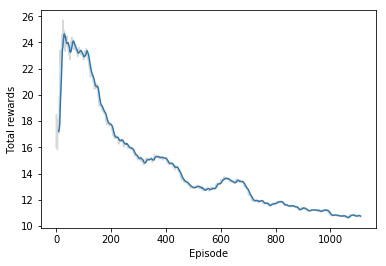

In [41]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

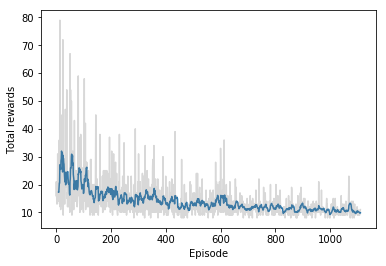

In [42]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

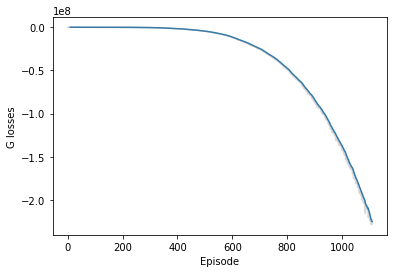

In [43]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

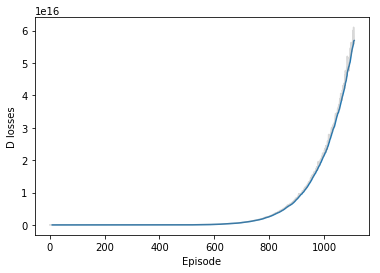

In [44]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.